In [20]:
import pandas as pd
import matplotlib.pyplot as plt
from pydeseq2.dds import DeseqDataSet
from pydeseq2.ds import DeseqStats
import numpy as np
import seaborn as sns
import gseapy as gp
import scipy.stats as stats
import plotly.express as px
from sklearn.decomposition import PCA
from statannotations.Annotator import Annotator
from skbio.stats.composition import multiplicative_replacement, clr
from sklearn.preprocessing import normalize

## 1. Replicate the First Plot (includes p-values) ##

Gene expression levels of select IFN signaling pathway genesare shown as fold change of nicotine exposed cells over their respective controls. UT: untreated BEAS-2B cells; UT-NTE: UT cells exposed to 2.5 μM nicotine; NiW: nickel washed-out cells; NiW-NTE: NiW cells exposed to 2.5 μM nicotine.

### Read in the Data and Filter ###

In [2]:
# Import the count data as a pandas df:
df = pd.read_csv('GSE242791_Nickel_Nicotine.csv', sep=',', index_col=0)
# Transpose for DEA
counts_df = df.T
# Filter out genes with less than 10 read counts in total:
genes_to_keep = counts_df.columns[counts_df.sum(axis=0) >= 10]
counts_df = counts_df[genes_to_keep]
counts_df

,ENSG00000223972,ENSG00000227232,ENSG00000278267,ENSG00000243485,ENSG00000237613,ENSG00000238009,ENSG00000233750,ENSG00000268903,ENSG00000269981,ENSG00000239906,...,ENSG00000278384,ENSG00000278066,ENSG00000276345,ENSG00000273532,ENSG00000276351,ENSG00000275661,ENSG00000271254,ENSG00000275405,ENSG00000277475,ENSG00000268674
B2Bcontrolrep1,23,1079,10,0,2,30,28,34,9,1,...,20,122,788,5,20,6,3475,2,20,0
B2Bcontrolrep2,26,1675,12,1,2,43,32,54,18,5,...,38,186,1461,11,32,5,6021,3,26,2
B2BNicotine125rep1,21,1382,10,2,3,50,38,36,9,4,...,19,150,1124,24,35,6,4653,7,19,0
B2BNicotine125rep2,16,1394,3,1,0,45,23,41,16,8,...,27,167,1233,26,34,9,4449,7,20,4
B2BNicotine250rep1,11,1278,8,4,1,32,21,35,15,1,...,20,134,1184,22,33,13,4341,0,30,0
B2BNicotine250rep2,32,2531,15,6,1,57,52,74,26,5,...,40,249,1950,38,65,11,7594,2,32,2
Hcontrolrep1,14,954,9,4,0,19,24,20,21,4,...,27,112,1081,17,15,10,3531,2,9,1
Hcontrolrep2,18,1382,4,2,0,31,37,54,15,4,...,38,159,1349,26,20,7,4406,3,21,3
Hcontrol125rep1,16,2071,16,15,0,51,55,82,32,10,...,45,192,1839,23,24,14,6444,4,41,3
Hcontrol125rep2,17,1249,6,2,0,26,34,42,16,3,...,36,131,1458,32,17,10,4449,5,8,1


In [3]:
# Sample and condition names:
rownames = list(counts_df.index)
groupnames = ['UT','UT','UT-NTE 1.25','UT-NTE 1.25','UT-NTE 2.5','UT-NTE 2.5',
              'NiW','NiW','NiW-NTE 1.25','NiW-NTE 1.25','NiW-NTE 2.5','NiW-NTE 2.5']

# Dataframe:
metadata = pd.DataFrame(
    {'sample': rownames,
     'condition': groupnames
    })
metadata.index = counts_df.index
metadata = metadata.drop(['sample'], axis=1)
metadata

,condition
B2Bcontrolrep1,UT
B2Bcontrolrep2,UT
B2BNicotine125rep1,UT-NTE 1.25
B2BNicotine125rep2,UT-NTE 1.25
B2BNicotine250rep1,UT-NTE 2.5
B2BNicotine250rep2,UT-NTE 2.5
Hcontrolrep1,NiW
Hcontrolrep2,NiW
Hcontrol125rep1,NiW-NTE 1.25
Hcontrol125rep2,NiW-NTE 1.25


### DESEQ2 ###

In [4]:
# Using DeseqDataSet for dds:
dds = DeseqDataSet(
    counts=counts_df,
    metadata=metadata,
    design_factors="condition", # Design by condition
    refit_cooks=True, # To improve accuracy and reduce impact of outliers
    n_cpus=6,
)

In [5]:
# Perform deseq2:
dds.deseq2()

# Get Stats results for the different treatment/control comparisons:
stat_res1 = DeseqStats(dds, contrast = ("condition", "UT-NTE 2.5", "UT"))
stat_res2 = DeseqStats(dds, contrast = ("condition", "NiW-NTE 2.5", "NiW"))

Fitting size factors...
... done in 0.02 seconds.

Fitting dispersions...
... done in 4.55 seconds.

Fitting dispersion trend curve...
... done in 0.54 seconds.

Fitting MAP dispersions...
... done in 5.43 seconds.

Fitting LFCs...
... done in 3.50 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 0 outlier genes.



In [6]:
# Compute the statistical summary results:
stat_res1.summary()
stat_res2.summary()

Running Wald tests...
... done in 2.68 seconds.

Running Wald tests...


Log2 fold change & Wald test p-value: condition UT-NTE 2.5 vs UT
                    baseMean  log2FoldChange     lfcSE      stat    pvalue  \
ENSG00000223972    19.941493       -0.648715  0.505044 -1.284472  0.198977   
ENSG00000227232  1564.069865        0.081266  0.093170  0.872238  0.383079   
ENSG00000278267    10.535160       -0.339078  0.729357 -0.464899  0.642004   
ENSG00000243485     3.997882        2.986383  1.782449  1.675438  0.093848   
ENSG00000237613     1.034165       -1.358390  2.260947 -0.600806  0.547969   
...                      ...             ...       ...       ...       ...   
ENSG00000275661     9.879912        0.808906  0.780101  1.036925  0.299771   
ENSG00000271254  5149.561946       -0.017975  0.055529 -0.323708  0.746159   
ENSG00000275405     3.781773       -1.768543  1.534169 -1.152770  0.249005   
ENSG00000277475    23.433189        0.120849  0.531583  0.227337  0.820162   
ENSG00000268674     1.680654       -0.359666  2.244439 -0.160248  0.872686   

... done in 1.95 seconds.



In [7]:
# Get the dataframes of the deseq statistic results:
ut_nte = stat_res1.results_df
niw_nte = stat_res2.results_df

In [8]:
# Get the rows for the genes wanted in the deseq statistic results dataframes:
hlaf_filtered_df1 = ut_nte.loc['ENSG00000204642',:]
hlaf_filtered_df2 = niw_nte.loc['ENSG00000204642',:]

ifim1_filtered_df1 = ut_nte.loc['ENSG00000185885',:]
ifim1_filtered_df2 = niw_nte.loc['ENSG00000185885',:]

irf6_filtered_df1 = ut_nte.loc['ENSG00000117595',:]
irf6_filtered_df2 = niw_nte.loc['ENSG00000117595',:]

mx1_filtered_df1 = ut_nte.loc['ENSG00000157601',:]
mx1_filtered_df2 = niw_nte.loc['ENSG00000157601',:]

### Plotting Bar Graphs ###

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

UT vs. UT-NTE: p=0.16228429791650592
NiW vs. NiW-NTE: p=9.613470698013981e-12
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

UT vs. UT-NTE: p=0.4432680121524002
NiW vs. NiW-NTE: p=4.3860047572944975e-10
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

UT vs. UT-NTE: p=9.555798164794266e-15
NiW vs. NiW-NTE: p=2.0308202077408714e-31
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e

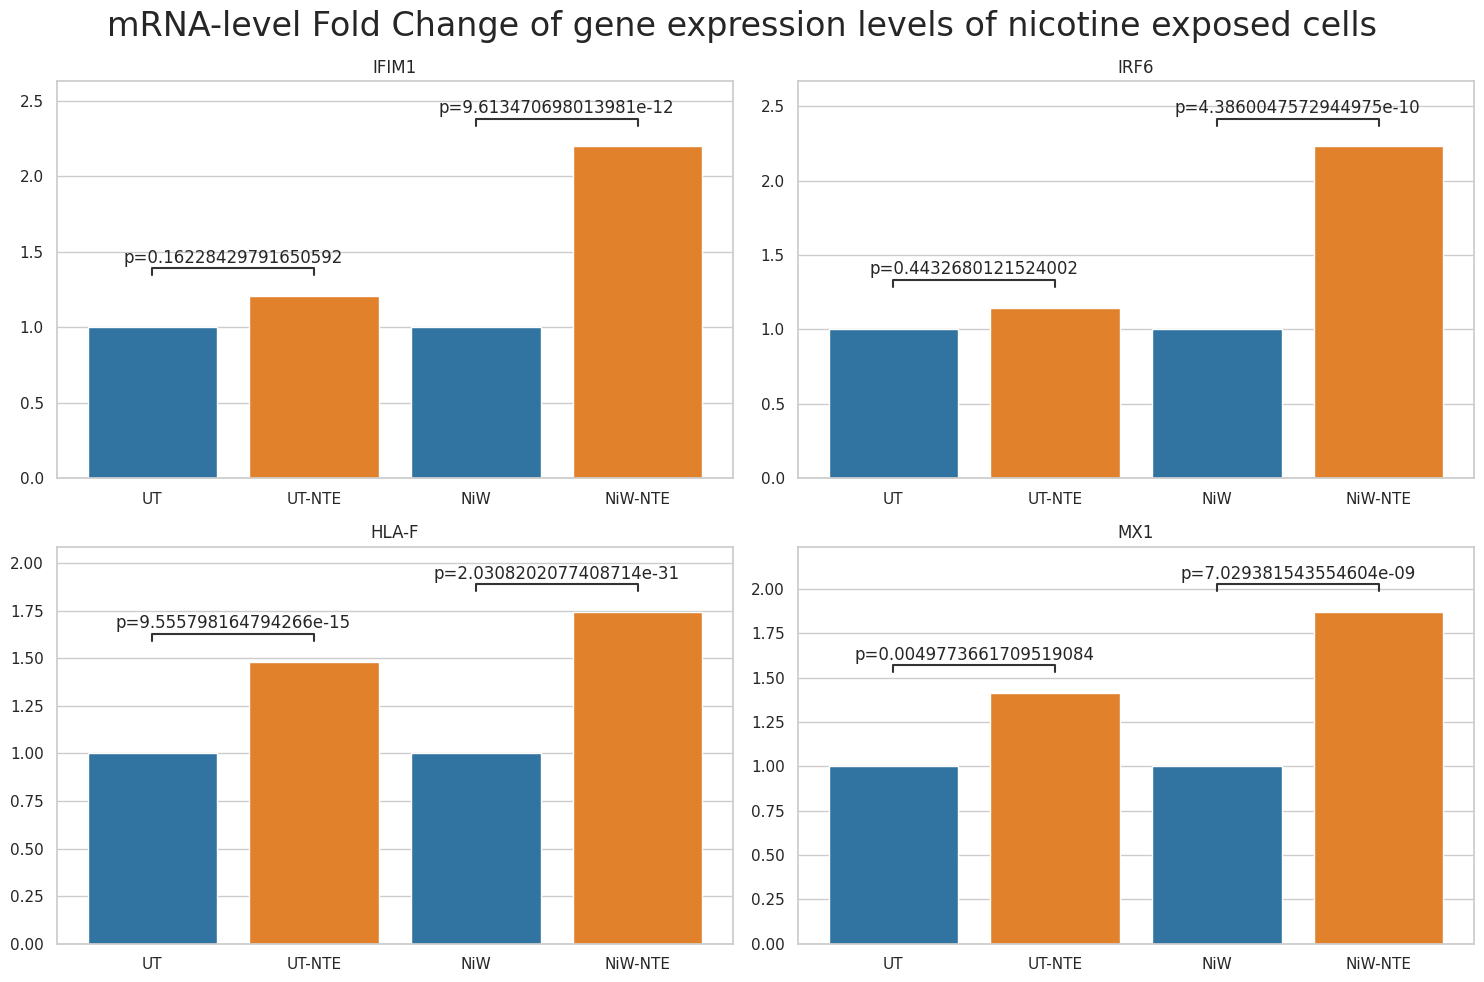

In [17]:
# Plotting bar graphs...
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15,10))
fig.subplots_adjust(hspace=0.5, wspace=0.125)
fig.suptitle('mRNA-level Fold Change of gene expression levels of nicotine exposed cells', fontsize=24)
# Define labels for x-axis
x_labels = ['UT','UT-NTE', 'NiW', 'NiW-NTE']
# Define bar colors
bar_colors = ['tab:blue', 'tab:orange', 'tab:blue', 'tab:orange']
#define the pairs for annotations
pairs = [('UT', 'UT-NTE'),
         ('NiW', 'NiW-NTE')] 

# IFIM1 PLOT:

# Construct the string containing the padj value
ifim1_pval1 = ifim1_filtered_df1.padj
ifim1_pval2 = ifim1_filtered_df2.padj
caption1 = ["p=" + str(ifim1_pval1), "p=" + str(ifim1_pval2)]

# Plot the bar plot for fold change values
sns.barplot(y=[1, 2**ifim1_filtered_df1.log2FoldChange, 1, 2**ifim1_filtered_df2.log2FoldChange], 
            x=x_labels, palette=bar_colors,ax=axes[0,0]).set(title='IFIM1')

# Create the p-values annotations
annotator1 = Annotator(axes[0,0], pairs, y=[1, 2**ifim1_filtered_df1.log2FoldChange, 1, 2**ifim1_filtered_df2.log2FoldChange], 
          x=x_labels, palette=bar_colors)
annotator1.set_custom_annotations(caption1)
annotator1.annotate()

# IRF6 PLOT:

# Construct the string containing the padj value
irf6_pval1 = irf6_filtered_df1.padj
irf6_pval2 = irf6_filtered_df2.padj
caption2 = ["p=" + str(irf6_pval1), "p=" + str(irf6_pval2)]

# Plot the bar plot for fold change values
sns.barplot(y=[1, 2**irf6_filtered_df1.log2FoldChange, 1, 2**irf6_filtered_df2.log2FoldChange], 
            x=x_labels, palette=bar_colors,ax=axes[0,1]).set(title='IRF6')

# Create the p-values annotations
annotator2 = Annotator(axes[0,1], pairs,y=[1, 2**irf6_filtered_df1.log2FoldChange, 1, 2**irf6_filtered_df2.log2FoldChange], 
            x=x_labels, palette=bar_colors)
annotator2.set_custom_annotations(caption2)
annotator2.annotate()

# HLAF PLOT:

# Construct the string containing the padj value
hlaf_pval1 = hlaf_filtered_df1.padj
hlaf_pval2 = hlaf_filtered_df2.padj
caption3 = ["p=" + str(hlaf_pval1), "p=" + str(hlaf_pval2)]

# Plot the bar plot for fold change values
sns.barplot(y=[1, 2**hlaf_filtered_df1.log2FoldChange, 1, 2**hlaf_filtered_df2.log2FoldChange], 
            x=x_labels, palette=bar_colors,ax=axes[1,0]).set(title='HLA-F')

# create the p-values annotations
annotator3 = Annotator(axes[1,0], pairs,y=[1, 2**hlaf_filtered_df1.log2FoldChange, 1, 2**hlaf_filtered_df2.log2FoldChange], 
           x=x_labels, palette=bar_colors)
annotator3.set_custom_annotations(caption3)
annotator3.annotate()

# MX1 PLOT:

# Construct the string containing the padj value
mx1_pval1 = mx1_filtered_df1.padj
mx1_pval2 = mx1_filtered_df2.padj
caption4 = ["p=" + str(mx1_pval1), "p=" + str(mx1_pval2)]

# Plot the bar plot for fold change values
sns.barplot(y=[1, 2**mx1_filtered_df1.log2FoldChange, 1, 2**mx1_filtered_df2.log2FoldChange], 
            x=x_labels, palette=bar_colors,ax=axes[1,1]).set(title='MX1')

# Create the p-values annotations
annotator4 = Annotator(axes[1,1], pairs,y=[1, 2**mx1_filtered_df1.log2FoldChange, 1, 2**mx1_filtered_df2.log2FoldChange], 
           x=x_labels, palette=bar_colors)
annotator4.set_custom_annotations(caption4)
annotator4.annotate()

# Fix the formatting
fig.tight_layout()

## 2. Create the PCA Plot ##

PCA plot of the gene expression profiles (RNA-Seq analysis). Each dot represents a replicate, which is labelled by the respective exposure conditions.

In [10]:
# Add a column for sample names into the df:
counts_df = counts_df.rename_axis("condition").reset_index()
counts_df

,condition,ENSG00000223972,ENSG00000227232,ENSG00000278267,ENSG00000243485,ENSG00000237613,ENSG00000238009,ENSG00000233750,ENSG00000268903,ENSG00000269981,...,ENSG00000278384,ENSG00000278066,ENSG00000276345,ENSG00000273532,ENSG00000276351,ENSG00000275661,ENSG00000271254,ENSG00000275405,ENSG00000277475,ENSG00000268674
0,B2Bcontrolrep1,23,1079,10,0,2,30,28,34,9,...,20,122,788,5,20,6,3475,2,20,0
1,B2Bcontrolrep2,26,1675,12,1,2,43,32,54,18,...,38,186,1461,11,32,5,6021,3,26,2
2,B2BNicotine125rep1,21,1382,10,2,3,50,38,36,9,...,19,150,1124,24,35,6,4653,7,19,0
3,B2BNicotine125rep2,16,1394,3,1,0,45,23,41,16,...,27,167,1233,26,34,9,4449,7,20,4
4,B2BNicotine250rep1,11,1278,8,4,1,32,21,35,15,...,20,134,1184,22,33,13,4341,0,30,0
5,B2BNicotine250rep2,32,2531,15,6,1,57,52,74,26,...,40,249,1950,38,65,11,7594,2,32,2
6,Hcontrolrep1,14,954,9,4,0,19,24,20,21,...,27,112,1081,17,15,10,3531,2,9,1
7,Hcontrolrep2,18,1382,4,2,0,31,37,54,15,...,38,159,1349,26,20,7,4406,3,21,3
8,Hcontrol125rep1,16,2071,16,15,0,51,55,82,32,...,45,192,1839,23,24,14,6444,4,41,3
9,Hcontrol125rep2,17,1249,6,2,0,26,34,42,16,...,36,131,1458,32,17,10,4449,5,8,1


In [11]:
# Get conditions columns from the df (sample names)
conditions = counts_df['condition']
# Drop for df to be numeric
counts_df = counts_df.drop('condition', axis=1)

In [12]:
# Compare to pulled out samples and ref to create new, grouped conditions
conditions = ['UT','UT','UT-NTE 1.25','UT-NTE 1.25','UT-NTE 2.5','UT-NTE 2.5',
              'NiW','NiW','NiW-NTE 1.25','NiW-NTE 1.25','NiW-NTE 2.5','NiW-NTE 2.5']

In [13]:
# Replace zeros to avoid log issues
data_no_zeros = multiplicative_replacement(counts_df.values)
# Apply the centered log-ratio transformation 
# Stabalize the variance in the dataframe
clr_transformed_data = clr(data_no_zeros)
# Normalize the transformed data
normalized_clr_data = normalize(clr_transformed_data)
# Convert the result back to a pandas df
clr_dataframe = pd.DataFrame(normalized_clr_data, columns=counts_df.columns, index=counts_df.index)

/usr4/bf591/vassanth/.local/lib/python3.10/site-packages/skbio/util/_warning.py:60: UserWarning: multiplicative_replacement is deprecated as of 0.6.0.
  warn(f"{func.__name__} is deprecated as of {ver}.")


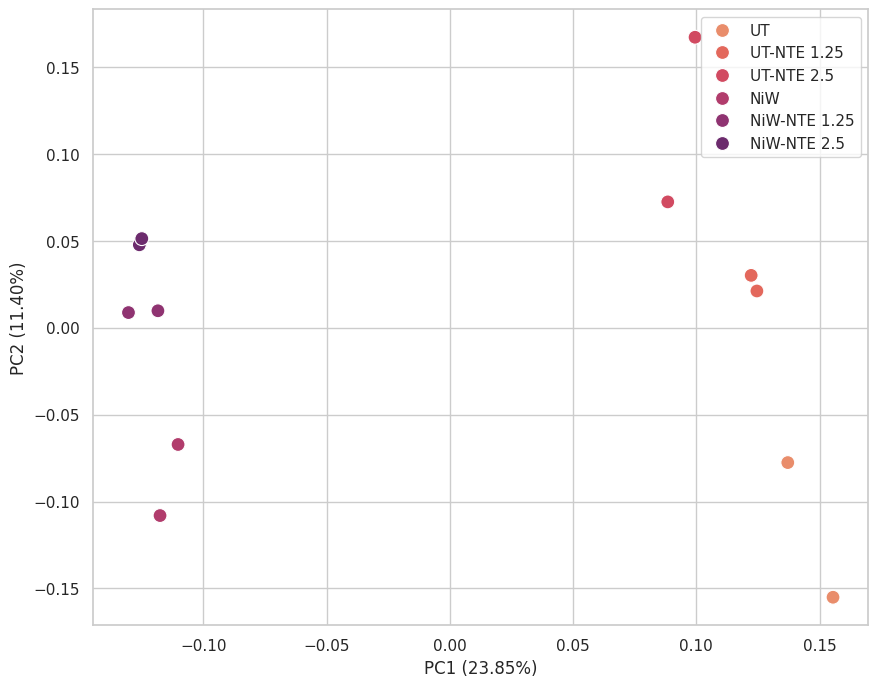

In [26]:
# Perform PCA
pca = PCA(n_components=2)
pc_scores = pca.fit_transform(clr_dataframe)

# Create a df with PC scores
pc_df = pd.DataFrame(data={'PC1': pc_scores[:, 0], 'PC2': pc_scores[:, 1], 'Condition': conditions})

# Percentage of variance explained by each PC
var_explained = pca.explained_variance_ratio_

# Plot pca plot - set fig size and style 
sns.set(style='whitegrid')
plt.figure(figsize=(10, 8))
sns.scatterplot(x='PC1', y='PC2', hue='Condition', data=pc_df, palette='flare', edgecolor='w', s=100)

# Plot %variance explained
# Add x and y labels and a title
plt.xlabel(f'PC1 ({var_explained[0]*100:.2f}%)')
plt.ylabel(f'PC2 ({var_explained[1]*100:.2f}%)')

plt.legend()
plt.savefig('pca_plot.png', dpi=300, bbox_inches='tight')
plt.show()

### Reactome Pathway Enrichment (Attempt): (Not inclusive to the main project) ###

In [23]:
# The gene symbols for upregulated genes:
upregulated_genes = [
    'HES4', 'LNCTAM34A', 'DISP3', 'FBXO2', 'PDPN', 'PADI2', 'CAMK2N1', 
    'RAP1GAP', 'GRHL3', 'MAN1C1'
]

enr = gp.enrichr(
    gene_list=upregulated_genes,  # List of gene symbols (index)
    gene_sets="Reactome_2016",   # Reactome pathway database
    organism='Human',            # Specify organism
    outdir=None                  # No output directory
)

# Convert enrichment results to a DataFrame
results_df = enr.results

# Filter significant pathways (adjusted p-value ≤ 0.05)
significant_results = results_df[results_df['Adjusted P-value'] <= 0.05]

# Check enrichment results
print(enr.results)


         Gene_set                                               Term Overlap  \
0   Reactome_2016  N-glycan trimming and elongation in the cis-Go...     1/5   
1   Reactome_2016          Rap1 signalling Homo sapiens R-HSA-392517    1/16   
2   Reactome_2016     Intra-Golgi traffic Homo sapiens R-HSA-6811438    1/44   
3   Reactome_2016  GPVI-mediated activation cascade Homo sapiens ...    1/53   
4   Reactome_2016  Adaptive Immune System Homo sapiens R-HSA-1280218   2/762   
5   Reactome_2016  Transport to the Golgi and subsequent modifica...   1/162   
6   Reactome_2016  Intra-Golgi and retrograde Golgi-to-ER traffic...   1/179   
7   Reactome_2016  Chromatin organization Homo sapiens R-HSA-4839726   1/226   
8   Reactome_2016  Chromatin modifying enzymes Homo sapiens R-HSA...   1/226   
9   Reactome_2016  Platelet activation, signaling and aggregation...   1/253   
10  Reactome_2016  Asparagine N-linked glycosylation Homo sapiens...   1/259   
11  Reactome_2016  Antigen processing: U